# LANL Earthquakes Experiment
# Spectrogram Analysis

This notebook continues from the point where Spectrogram_librosa.ipynb created a directory of spectrograms made using librosa library.

TODO:
* Estimate statistical dependence when multiplying probabilities
* Apply prior distribution knowledge.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import seaborn as sns
import re
from pathlib import Path
import pickle as pkl
from time import time
from tqdm import tqdm, tnrange, tqdm_notebook
from pprint import pprint
import os, sys
from warnings import warn
import itertools
from sklearn.model_selection import KFold, StratifiedKFold
from fastai.vision import *
from fastai.metrics import error_rate#, mean_absolute_error

In [3]:
# Path consts
BASE = Path('../Data')
TRAIN = BASE/'train_spec4'
TEST = BASE/'test_spec4'

# NN consts
BS = 32 # 64 already causes OOM error in the regression
MIXUP = True

# Data consts
SIZE = (143,156)
meta = pd.read_csv(TRAIN/'train_spec_meta.csv')
n_hops = len(meta)

## Classification

In [4]:
class Probs:

    def __init__(self, thresholds=(0,0.1917,1,2,3,4,5,6,7,8,9,10,12,16), intervals=None, prior=None, probs=None, n_samples=None):
        self.intervals = intervals if intervals is not None else list((ti,tf) for ti,tf in zip(thresholds[:-1],thresholds[1:]))
        self.n_ints = len(self.intervals)
        self.lens = [I[1]-I[0] for I in self.intervals]
        self.means = [(I[0]+I[1])/2 for I in self.intervals]
        self.prior = prior if prior is not None else np.repeat(np.array(1/self.n_ints), self.n_ints)
        self.prior = self.prior / np.sum(self.prior)
        self.probs = None
        if probs is None:
            self.initialize_probs(n_sampels)
        elif type(probs) in (list,tuple):
            self.probs = self.list2mat(probs)
        else:
            self.probs = probs
        self.n_samples = self.probs.shape[0]

    def initialize_probs(self, n_samples):
        self.probs = np.ones(n_samples, self.n_ints)
        self.probs = np.apply_along_axis(lambda p: np.multiply(p,self.prior),1,self.probs) # TODO either 0 or 1 axis...

    def list2mat(self, probs):
        return np.array(probs)

    def update_probs(self, p):
        if type(p) in (list,tuple):
            p = self.list2mat(p)
        elif type(p) is Probs:
            p = p.probs
        self.probs = self.probs.multiply(p)

    def get_meds(self):
        m = []
        for row in self.probs: # TODO numpy iterate over rows
            cs = np.cumsum(row)
            i0 = int(np.argwhere(cs>0.5)[0][0])
            ti,tf = self.intervals[i0]
            c0 = cs[i0-1] if i0>0 else 0
            m.append( ti + (tf-ti) * (0.5-c0) / (cs[i0]-c0) )
        return np.array(m)

    def get_MLs(self):
        return np.array([self.means[np.argmax(row)] for row in self.probs]) # TODO numpy iterate over rows

    def get_means(self):
        return np.array([np.sum(row*self.means) for row in self.probs]) # TODO numpy iterate over rows

    def expected_errors(self, preds=None):
        if preds is None:
            preds = self.get_meds()
        raise NotImplementedError()

    # TODO visualizations etc.

In [5]:
def classification_data(class_limits=(0,0,1,2,3,4,5,6,7,8,10,12,99), verbose=1):
#     fnames = [str(TRAIN/nm) for nm in os.listdir(TRAIN) if nm.endswith('.png')]
#     x = ImageDataBunch.from_name_func(path=TRAIN, fnames=fnames, test=TEST, valid_pct=0, ds_tfms=[], size=SIZE, bs=BS,
#                                       label_func=lambda nm: nm[-9:-4],
#                                       classes = [f'{a:02d}-{b:02d}' for a,b in zip(class_limits[:-1],class_limits[1:])])
    data = ImageDataBunch.from_folder(
        path=TRAIN, train=TRAIN, test='../test_spec4', valid_pct=0, ds_tfms=[], size=SIZE, bs=BS,
        classes = [f'{a:02d}-{b:02d}' for a,b in zip(class_limits[:-1],class_limits[1:])]
    ).normalize()
    
    classification_data_info(data, verbose)

    return data

def classification_data_info(data, verbose):
    if verbose >= 1:
        print(data)
    if verbose >= 2:
        data.show_batch(rows=3, figsize=(9,6))
    
def classes2times(cls):
    return np.array([class2time(c) for c in cls])

def class2time(c):
    t = (int(c[:2])+int(c[-2:]))/2
    return min(t,13)

In [6]:
data = classification_data(verbose=1)
learn = cnn_learner(data, models.resnet34, metrics=error_rate).mixup()

C:\Users\idogr\Anaconda3\envs\fastai_v1\lib\site-packages\fastai\data_block.py:525: UserWarning: You are labelling your items with CategoryList.
Your train set contained the following unknown labels, the corresponding items have been discarded.
train_spec4
  if getattr(ds, 'warn', False): warn(ds.warn)


ImageDataBunch;

Train: LabelList (25160 items)
x: ImageList
Image (3, 143, 156),Image (3, 143, 156),Image (3, 143, 156),Image (3, 143, 156),Image (3, 143, 156)
y: CategoryList
0,0,0,0,0
Path: ..\Data\train_spec4;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: ..\Data\train_spec4;

Test: LabelList (2624 items)
x: ImageList
Image (3, 143, 156),Image (3, 143, 156),Image (3, 143, 156),Image (3, 143, 156),Image (3, 143, 156)
y: EmptyLabelList
,,,,
Path: ..\Data\train_spec4


In [7]:
test_names = [item.name[:-4] for item in data.test_ds.x.items]

In [8]:
DO_PREDICT = False

if DO_PREDICT:
    RES = []
    for fold in range(5):
        print(f'Fold: {fold:d}')
        learn.load(f'model_spec_class_refined_resnet34_freezed_mxp1_'+str(fold))
        y = learn.get_preds(DatasetType.Test)[0]
        RES.append(np.array(y))

    print([r.shape for r in RES])

    with open(TRAIN/f'classification_refined_results_mixup{MIXUP:d}_freezed_test.pkl','wb') as fd:
        pkl.dump(RES, fd)
    
    torch.cuda.empty_cache()
        
else:
    with open(TRAIN/f'classification_refined_results_mixup{MIXUP:d}_freezed_test.pkl','rb') as fd:
        RES = pkl.load(fd)
        for i in range(len(RES)):
            RES[i] = np.array(RES[i])

Text(0, 0.5, 'Mean Probability')

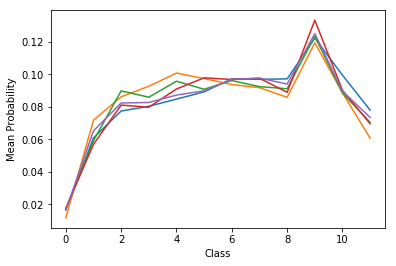

In [9]:
# mean distribution of each model
for i in range(5):
    plt.plot(np.apply_along_axis(np.mean, 0, RES[i]))
plt.xlabel('Class')
plt.ylabel('Mean Probability')

In [10]:
def get_med(probs, class_limits=(0,0.1917,1,2,3,4,5,6,7,8,10,12,16)):
    cs = np.cumsum(probs)
    i0 = int(np.argwhere(cs>0.5)[0][0])
    ti = class_limits[i0]
    tf = class_limits[i0+1]
    c0 = cs[i0-1] if i0>0 else 0
    return ti + (tf-ti) * (0.5-c0) / (cs[i0]-c0)

meds = list()
for i in range(5):
    meds.append(np.apply_along_axis(get_med, 1, np.array(RES[i])))
meds = np.array(meds)
meds

array([[6.037187, 6.206592, 5.572003, 8.046411, ..., 6.432078, 4.628982, 1.922302, 8.381265],
       [5.955882, 5.365289, 5.90369 , 8.165489, ..., 6.130956, 4.134076, 2.366848, 9.027561],
       [5.991173, 4.554383, 6.088174, 8.806861, ..., 5.791393, 4.596335, 1.825242, 9.293565],
       [6.766256, 4.87453 , 5.636733, 8.797453, ..., 5.819589, 5.121412, 2.038478, 8.260816],
       [6.174999, 5.270439, 6.066412, 8.431896, ..., 6.652803, 4.823541, 1.969457, 8.909721]])

In [11]:
np.corrcoef(meds)

array([[1.      , 0.970467, 0.970052, 0.968828, 0.971869],
       [0.970467, 1.      , 0.972054, 0.968994, 0.97067 ],
       [0.970052, 0.972054, 1.      , 0.971608, 0.97405 ],
       [0.968828, 0.968994, 0.971608, 1.      , 0.971329],
       [0.971869, 0.97067 , 0.97405 , 0.971329, 1.      ]])

In [12]:
# L1-differences between medians
mean_absolute_distance = lambda x: np.array([[np.mean(np.abs(x1-x2)) for x2 in x] for x1 in x])
mean_absolute_distance(meds)

array([[0.      , 0.565156, 0.494797, 0.489479, 0.467656],
       [0.565156, 0.      , 0.447025, 0.517079, 0.494937],
       [0.494797, 0.447025, 0.      , 0.447535, 0.430799],
       [0.489479, 0.517079, 0.447535, 0.      , 0.461441],
       [0.467656, 0.494937, 0.430799, 0.461441, 0.      ]])

In [13]:
def expected_errors(probs, Y, ts=(0,0.1917,1,2,3,4,5,6,7,8,10,12,16)):
    return [np.sum([p*np.abs((tf-ti)/3 if ti<=y<tf else ((ti+tf)/2-y))
                    for p,ti,tf in zip(P,ts[:-1],ts[1:])])
            for P,y in zip(probs,Y)]

In [14]:
[np.mean(expected_errors(r, m)) for r,m in zip(RES,meds)]

[2.390928869799811,
 2.2508880892311023,
 2.3335470956603834,
 2.361372658403817,
 2.345979813257258]

In [15]:
np.corrcoef([expected_errors(r, m) for r,m in zip(RES,meds)])

array([[1.      , 0.864115, 0.843607, 0.833959, 0.843988],
       [0.864115, 1.      , 0.838409, 0.85409 , 0.847349],
       [0.843607, 0.838409, 1.      , 0.825829, 0.83397 ],
       [0.833959, 0.85409 , 0.825829, 1.      , 0.843974],
       [0.843988, 0.847349, 0.83397 , 0.843974, 1.      ]])

In [16]:
naive_stacking = meds.mean(axis=0)
naive_stacking

array([6.1851  , 5.254246, 5.853403, 8.449622, ..., 6.165364, 4.660869, 2.024465, 8.774586])

In [17]:
def stack_probs(PROBS, I=1):
    stacked_probs = np.ones(PROBS[0].shape)
    for r in PROBS:
        stacked_probs *= r
    stacked_probs = stacked_probs ** (I/len(PROBS))
    stacked_probs = stacked_probs / stacked_probs.sum(axis=1)[:,np.newaxis]
    prob_stacking = np.apply_along_axis(get_med, 1, stacked_probs)
    return stacked_probs, prob_stacking

In [18]:
stacked_probs, prob_stacking = stack_probs(RES, 5)
aggressive_prob_stacking = prob_stacking

1.2715616198189816

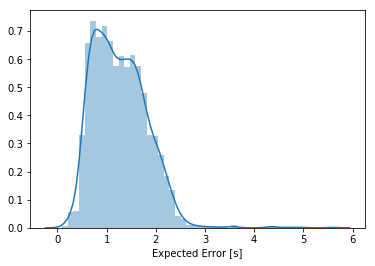

In [19]:
sns.distplot(expected_errors(stacked_probs, prob_stacking))
plt.xlabel('Expected Error [s]')
np.mean(expected_errors(stacked_probs, prob_stacking))

In [20]:
mean_absolute_distance((naive_stacking,prob_stacking))

array([[0.      , 0.962679],
       [0.962679, 0.      ]])

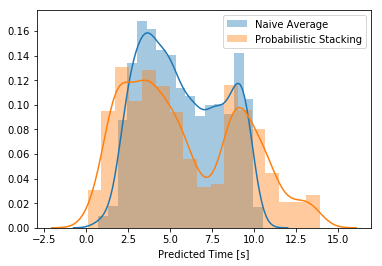

In [21]:
sns.distplot(naive_stacking, label='Naive Average')
sns.distplot(prob_stacking, label='Probabilistic Stacking')
plt.xlabel('Predicted Time [s]')
plt.legend()

In [22]:
i0 = np.argmax(prob_stacking-naive_stacking)
print(naive_stacking[i0])
print(prob_stacking[i0])

8.162356808555618
13.207164032428317


In [23]:
print((0,0.1917,1,2,3,4,5,6,7,8,10,12,99))
tmp = np.apply_along_axis(np.prod,0,np.array([np.round(r[i0,:],3) for r in RES]))**(1/5)
print(np.round(tmp / tmp.sum(), 3))
[np.round(r[i0,:],3) for r in RES]

(0, 0.1917, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 99)
[0.071 0.007 0.01  0.01  0.017 0.041 0.084 0.12  0.132 0.153 0.135 0.219]


[array([0.118, 0.01 , 0.011, 0.011, 0.014, 0.03 , 0.083, 0.133, 0.139, 0.133, 0.125, 0.192], dtype=float32),
 array([0.04 , 0.008, 0.011, 0.01 , 0.02 , 0.049, 0.066, 0.109, 0.134, 0.173, 0.142, 0.237], dtype=float32),
 array([0.091, 0.006, 0.008, 0.009, 0.02 , 0.046, 0.088, 0.089, 0.112, 0.118, 0.135, 0.278], dtype=float32),
 array([0.061, 0.009, 0.01 , 0.009, 0.016, 0.034, 0.07 , 0.125, 0.133, 0.183, 0.131, 0.219], dtype=float32),
 array([0.063, 0.005, 0.008, 0.01 , 0.016, 0.049, 0.113, 0.144, 0.134, 0.156, 0.132, 0.169], dtype=float32)]

In [24]:
stacked_probs, prob_stacking = stack_probs(RES, 1.15)

2.2282950351310395

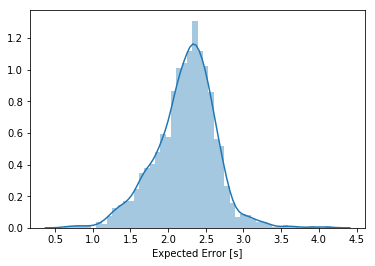

In [25]:
sns.distplot(expected_errors(stacked_probs, prob_stacking))
plt.xlabel('Expected Error [s]')
np.mean(expected_errors(stacked_probs, prob_stacking))

In [26]:
mean_absolute_distance((naive_stacking,prob_stacking))

array([[0.      , 0.131729],
       [0.131729, 0.      ]])

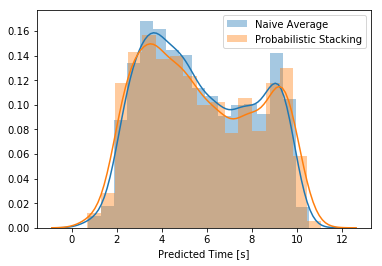

In [27]:
sns.distplot(naive_stacking, label='Naive Average')
sns.distplot(prob_stacking, label='Probabilistic Stacking')
plt.xlabel('Predicted Time [s]')
plt.legend()

In [28]:
i0 = np.argmax(prob_stacking-naive_stacking)
print(naive_stacking[i0])
print(prob_stacking[i0])

2.518812341801655
3.8168003180374974


In [29]:
print((0,0.1917,1,2,3,4,5,6,7,8,10,12,99))
tmp = np.apply_along_axis(np.prod,0,np.array([np.round(r[i0,:],3) for r in RES]))**(1/5)
print(np.round(tmp / tmp.sum(), 3))
[np.round(r[i0,:],3) for r in RES]

(0, 0.1917, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 99)
[0.387 0.03  0.011 0.013 0.017 0.057 0.095 0.077 0.077 0.109 0.087 0.041]


[array([0.397, 0.026, 0.009, 0.014, 0.019, 0.053, 0.118, 0.074, 0.084, 0.105, 0.073, 0.029], dtype=float32),
 array([0.129, 0.027, 0.019, 0.019, 0.03 , 0.114, 0.133, 0.099, 0.128, 0.144, 0.105, 0.054], dtype=float32),
 array([0.528, 0.021, 0.015, 0.012, 0.015, 0.048, 0.071, 0.061, 0.043, 0.085, 0.061, 0.04 ], dtype=float32),
 array([0.484, 0.046, 0.008, 0.011, 0.015, 0.033, 0.07 , 0.062, 0.068, 0.079, 0.077, 0.046], dtype=float32),
 array([0.476, 0.025, 0.007, 0.007, 0.007, 0.046, 0.07 , 0.068, 0.06 , 0.108, 0.098, 0.029], dtype=float32)]

In [30]:
def save_results(names, preds, filename):
    df = pd.DataFrame({'seg_id':names, 'time_to_failure':preds})
    if not filename.endswith('.csv'):
        filename += '.csv'
    df.to_csv(filename, index=False)
    return df

tmp = save_results(test_names, naive_stacking, 'submission_spect_manual_class_naive')
tmp = save_results(test_names, aggressive_prob_stacking, 'submission_spect_manual_class_agg_prob')
tmp = save_results(test_names, prob_stacking, 'submission_spect_manual_class_prob')
tmp.head()

,seg_id,time_to_failure
0,seg_00030f,6.282830
1,seg_0012b5,5.195931
2,seg_00184e,5.881454
3,seg_003339,8.678295
4,seg_0042cc,6.295842


In [31]:
raise Exception('hello')

Exception: hello

## Regression

Note: range of MAE should be between 2.0 (excellent) and 2.2 (quite bad), for CV that takes groups of 20 x3-augmented-segments (i.e. 7 original segments, or 1.05M samples) as homogeneous buckets.

In [ ]:
def regression_data(meta, fold, verbose=1):
    validation_set = {nm: k for nm,k in zip(meta.filename,meta.fold)}
    
    data = (PointsItemList.from_folder(TEST)
            .split_by_valid_func(lambda nm: validation_set[os.path.basename(nm)]==fold)
            .label_from_df(cols='time', label_cls=FloatList)
            .transform(size=SIZE)
            .databunch()).normalize()
    data.batch_size = BS
    # Note: normalize() uses by default self.stats = self.batch_stats() = [torch.mean,torch.std].
    # This should be good since we have very weird values and we wish to normalize them to nore conventional values.
    # RESNET34 kind of assumes a more specific input distribution (imagenet_stats),
    # but as far as we don't have convergence issues, we'll stick to this.
    
    regression_data_info(data, verbose)
    
    return data

def regression_data_info(data, verbose):
    if verbose >= 1:
        print(data)
        plt.figure(figsize=(8,5))
        sns.distplot(data.label_list.train.y.items, color='b', hist=True, label='Train')
        sns.distplot(data.label_list.valid.y.items, color='r', hist=True, label='Valid')
        plt.xlabel('TTF')
        plt.legend()
        plt.grid()
    if verbose >= 2:
        data.show_batch(rows=3, figsize=(9,6))

In [ ]:
def regression_learn(data, lr_range=(3e-5,3e-4), cycles=(4,2), mixup=True,
                     save_label=None, load=False, predict=True, find_lr=True):
    
    # initialize
    learn = cnn_learner(data, models.resnet34, loss_func=mean_absolute_error, metrics=mean_absolute_error)
    learn.loss = F.l1_loss
    if mixup:
        learn.mixup()
    
    # train
    if load:
        if load == 'freezed':
            learn.load(f'model_spec_reg_resnet34_freezed_mxp{mixup:d}_'+save_label)
        elif load == 'unfreezed':
            learn.load(f'model_spec_reg_resnet34_unfreezed_mxp{mixup:d}_'+save_label)
        else:
            raise ValueError("load must be either 'freezed' or 'unfreezed'.")
        
    else:
        # TODO track training errors (on both train & validation sets)
        if cycles[0] > 0:
            learn.fit_one_cycle(cycles[0])
            if save_label is not None:
                learn.save(f'model_spec_reg_resnet34_freezed_mxp{mixup:d}_'+save_label)

        if find_lr:
            learn.lr_find()
            learn.recorder.plot()

        if cycles[1] > 0:
            learn.unfreeze()
            learn.fit_one_cycle(cycles[1], max_lr=slice(lr_range[0],lr_range[1]))
            if save_label is not None:
                learn.save(f'model_spec_reg_resnet34_unfreezed_mxp{mixup:d}_'+save_label)
    
    # predict
    if predict:
        #out = learn.get_preds(learn.data)
        yt0 = None # out[1]
        yt = None # np.reshape(out[0], (out[0].shape[0],))
        yv0 = learn.data.label_list.valid.y.items
        yv = np.array([learn.predict(x)[0].data[0] for x in tqdm_notebook(learn.data.label_list.valid.x)])
        # ridiculously can't find any better way to get validation predictions. maybe try generalizing from this:
        # np.array(model.get_preds(ds_type=DatasetType.Valid)[0])
    else:
        yt0, yt, yv0, yv = (None for _ in range(4))
    
    return learn, yt0, yt, yv0, yv

def mean_absolute_error(pred:Tensor, targ:Tensor, reduction=None)->Rank0Tensor:
    "Mean absolute error between `pred` and `targ`."
    """ A copied version of FastAI function with additional 'reduction' argument,
    in sake of compatibility with up-to-date Pytorch. """
    pred,targ = flatten_check(pred,targ)
    errs = torch.abs(targ.float() - pred.float())
    if reduction is None or reduction=='mean':
        return errs.mean()
    if reduction=='none':
        return errs
    return errs.sum()

# class L1LossFlat(nn.L1Loss):
#     '''Mean Absolute Error Loss; seems that it is not necessary anymore, and F.l1_loss does fine.'''
#     def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
#         return super().forward(input.view(-1), target.view(-1))
# learn.loss = L1LossFlat

In [ ]:
if RUN_REGRESSION:

    LOAD_ONLY = 'unfreezed' if RUN_REGRESSION==1 else False

    K = len(np.unique(meta.fold))
    print(f'Number of folders:\t{K:d}')

    YV0 = meta.time
    YV = np.zeros(len(meta))
    for k in range(0,K):
        print('Iteration: ',k)
        data = regression_data(meta, k, verbose = (2 if k==0 else 0))
        learn, yt0, yt, yv0, yv = regression_learn(data, cycles=(4,3), mixup=MIXUP, save_label=f'{k:d}', load=LOAD_ONLY)
        YV[meta.fold==k] = yv
        # clean
        del learn, data
        torch.cuda.empty_cache()
    
    YV_crop = np.maximum(np.minimum(YV, 16.5), 0)

    with open(TRAIN/f'regression_results_mixup{MIXUP:d}_unfreezed.pkl','wb') as fd:
        pkl.dump((YV0, YV, YV_crop), fd)
    
    
else:
    
    with open(TRAIN/f'regression_results_mixup{MIXUP:d}_unfreezed.pkl','rb') as fd:
        YV0, YV, YV_crop = pkl.load(fd)

In [ ]:
analyze_errors(YV0, YV_crop, 'Regression', meta.fold.values)

In [ ]:
if CLASSIFICATION_DONE: class_vs_reg(YV0, YV_crop, YV_MED)

In [ ]:
torch.cuda.empty_cache()